## ディープラーニング向けライブラリの導入

### Keras

In [3]:
import numpy as np
import tensorflow as tf

np.random.seed(123)
tf.random.set_seed(123)

#### データの準備

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

N = 300
x, t = datasets.make_moons(N, noise=0.3)
t = t.reshape(N, 1)

x_train, x_test, t_train, t_test = \
    train_test_split(x, t, test_size=0.2)

#### モデル構築

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
# 次元3の隠れ層
model.add(Dense(3, activation='sigmoid', input_dim=2))
# 次元１の出力層
model.add(Dense(1, activation='sigmoid'))

#### モデル学習

In [5]:
from tensorflow.keras import optimizers

# 学習方法は確率的勾配法(SGD)
optimizer = optimizers.SGD(learning_rate=0.1)
# 誤差関数は交差エントロピー、評価指標は正解率
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# verbose
# 0：ログ出力なし、1：プログレスバー表示、２：エポックごとに１行出力
model.fit(x_train, t_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
24/24 [==============================] - 0s 1ms/step - loss: 0.7579 - accuracy: 0.2792
Epoch 2/100
24/24 [==============================] - 0s 1ms/step - loss: 0.7149 - accuracy: 0.3958
Epoch 3/100
24/24 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.5167
Epoch 4/100
24/24 [==============================] - 0s 1ms/step - loss: 0.6596 - accuracy: 0.6833
Epoch 5/100
24/24 [==============================] - 0s 1ms/step - loss: 0.6353 - accuracy: 0.8000
Epoch 6/100
24/24 [==============================] - 0s 955us/step - loss: 0.6144 - accuracy: 0.8125
Epoch 7/100
24/24 [==============================] - 0s 960us/step - loss: 0.5940 - accuracy: 0.8125
Epoch 8/100
24/24 [==============================] - 0s 1ms/step - loss: 0.5769 - accuracy: 0.8292
Epoch 9/100
24/24 [==============================] - 0s 939us/step - loss: 0.5593 - accuracy: 0.8125
Epoch 10/100
24/24 [==============================] - 0s 1ms/step - loss: 0.5422 - accuracy: 0.8125
Epo

#### モデル評価

In [6]:
loss, acc = model.evaluate(x_test, t_test, verbose=0)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(loss,acc))

test_loss: 0.310, test_acc: 0.883


### Tensorflow

#### モデル構築

1. KerasのModelを継承させる
2. 順伝播のメソッド名はcallにする

In [7]:
from tensorflow.keras.models import Model

class MLP(Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = Dense(hidden_dim, activation='sigmoid')
        self.l2 = Dense(output_dim, activation='sigmoid') 
        
    def call(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y

In [8]:
model = MLP(3,1)

#### モデル学習

- tensorflowでグラフが構築されるのは、データに値が与えられたとき。
- @tf.functionをつけておくと、その関数を使う際は、最初に構築されたグラフを元に計算され、その都度構築されない。高速化。
- 一方で、tf以外のメソッドを使うと、エラーが発生する

In [9]:
from tensorflow.keras import losses

criterion = losses.BinaryCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.1)

def compute_loss(t, y):
    return criterion(t, y)

@tf.function
def train_step(x, t):
    '''誤差伝播計算'''
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = compute_loss(t, preds)
    # lossに対するモデルのパラメータの勾配を計算
    grads = tape.gradient(loss, model.trainable_variables)
    # 上で求めた勾配でパラメータ更新
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [10]:
epochs = 100
batch_size = 10
n_batches = x_train.shape[0] // batch_size

In [11]:
from sklearn.utils import shuffle

for epoch in range(epochs):
    train_loss = 0
    x_, t_ = shuffle(x_train, t_train)
    
    # ミニバッチ学習
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        loss = train_step(x_[start:end], t_[start:end])
        # 値を取り出すには、.numpyが必要
        train_loss += loss.numpy()
    
    print('epoch:{}, loss:{:.3}'.format(
        epoch+1,
        train_loss
    ))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch:1, loss:16.6
epoch:2, loss:16.5
epoch:3, loss:16.3
epoch:4, loss:16.2
epoch:5, loss:16.0
epoch:6, loss:15.8
epoch:7, loss:15.5
epoch:8, loss:15.3
epoch:9, loss:15.0
epoch:10, loss:14.7
epoch:11, loss:14.3
epoch:12, loss:14.0
epoch:13, loss:13.7
epoch:14, loss:13.3
epoch:15, loss:13.0
epoch:16, loss:12.7
epoch:17, loss:12.4
epoch:18, loss:12.2
epoch:19, loss:12.0
epoch:20, loss:11.8
epoch:21, loss:11.6
epoch:22, loss:11.4
epoch:23, loss:11.2
epoch:24, loss:11.1
epoch:25, loss:11.0
epoch:26, loss:10

#### モデル評価

In [12]:
from tensorflow.keras import metrics

test_loss = metrics.Mean()
test_acc = metrics.BinaryAccuracy()

def test_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    test_loss(loss)
    test_acc(t, preds)
    return preds

test_step(x_test, t_test)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss.result(), test_acc.result()))

test_loss: 0.309, test_acc: 0.867


### Pytorch

- TnsorFlow(およびKeras)では、GPUに対応した実装かどうかは、ライブラリのインストール時に決まる
- Pytorchでは、<span class="burk"><span class="girk">GPUを使用するかどうかは、deviceを定義するコードで決定する</span></span>、（コードの変更がないところが良い。）

In [21]:
import torch

np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### モデルの構築

In [24]:
import torch.nn as nn

class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_dim, output_dim)
        self.a2 = nn.Sigmoid()
        
        self.layers = [self.l1, self.a1, self.l2, self.a2]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [25]:
model = MLP(2,3,1).to(device)

#### モデルの学習

In [41]:
import torch.optim as optimizers

criterion = nn.BCELoss()
optimizer = optimizers.SGD(model.parameters(), lr=0.1)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [42]:
epochs = 100
batch_size = 10
n_batches = x_train.shape[0] // batch_size

In [44]:
for epoch in range(epochs):
    train_loss = 0.
    x_, t_ = shuffle(x_train, t_train)
    # numpyを明示的にtensorに変換する必要あり
    x_ = torch.Tensor(x_).to(device)
    t_ = torch.Tensor(t_).to(device)
    
    for n_batch in range(n_batches):
        start = n_batch * batch_size
        end = start + batch_size
        loss = train_step(x_[start:end], t_[start:end])
        train_loss += loss.item()
        
    print('epoch: {}, loss: {:.3}'.format(epoch+1, train_loss))

epoch: 1, loss: 16.7
epoch: 2, loss: 16.5
epoch: 3, loss: 16.3
epoch: 4, loss: 16.1
epoch: 5, loss: 15.9
epoch: 6, loss: 15.6
epoch: 7, loss: 15.3
epoch: 8, loss: 14.9
epoch: 9, loss: 14.5
epoch: 10, loss: 14.1
epoch: 11, loss: 13.7
epoch: 12, loss: 13.3
epoch: 13, loss: 12.9
epoch: 14, loss: 12.5
epoch: 15, loss: 12.2
epoch: 16, loss: 11.9
epoch: 17, loss: 11.7
epoch: 18, loss: 11.4
epoch: 19, loss: 11.2
epoch: 20, loss: 11.0
epoch: 21, loss: 10.9
epoch: 22, loss: 10.7
epoch: 23, loss: 10.6
epoch: 24, loss: 10.5
epoch: 25, loss: 10.4
epoch: 26, loss: 10.3
epoch: 27, loss: 10.2
epoch: 28, loss: 10.1
epoch: 29, loss: 10.1
epoch: 30, loss: 10.0
epoch: 31, loss: 9.96
epoch: 32, loss: 9.91
epoch: 33, loss: 9.85
epoch: 34, loss: 9.83
epoch: 35, loss: 9.78
epoch: 36, loss: 9.76
epoch: 37, loss: 9.76
epoch: 38, loss: 9.7
epoch: 39, loss: 9.67
epoch: 40, loss: 9.65
epoch: 41, loss: 9.66
epoch: 42, loss: 9.63
epoch: 43, loss: 9.61
epoch: 44, loss: 9.57
epoch: 45, loss: 9.58
epoch: 46, loss: 9.5

#### モデルの評価

In [45]:
def test_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    # 推論モードは指定する必要あり
    model.eval()
    preds = model(x)
    loss = compute_loss(t, preds)
    return loss, preds

In [59]:
from sklearn.metrics import accuracy_score

loss, preds = test_step(x_test, t_test)
test_loss = loss.item()
# tensorからnumpyに変換。CPUのテンソル型でないと行けない。
preds = preds.data.cpu().numpy() > 0.5
test_acc = accuracy_score(t_test, preds)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss, test_acc))

test_loss: 0.310, test_acc: 0.883


## ディープラーニングへの準備

### MNIST
- 0~9までの数字の手書きデータ
- 学習用データ60,000枚、テスト用データ10,000枚
- 各画像は28×28ピクセル

In [67]:
from tensorflow.keras import datasets

mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

In [71]:
# モデルの入力に合わせるために、28×28=784次元に整形
# 画素値を0-1に規格化
x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_test = (x_test.reshape(-1,784)/255).astype(np.float32)

# １０次元の単位行列から、正解ベクトルを生成
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

#### ２００次元の隠れ層を実装

In [78]:
model = Sequential()
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [79]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, t_train, epochs=30, batch_size=100, verbose=2)

loss, acc = model.evaluate(x_test, t_test, verbose=0)
print('test_acc: {:.3f}, test_acc:{:.3f}'.format(loss, acc))

Epoch 1/30
600/600 - 1s - loss: 1.9206 - accuracy: 0.5753
Epoch 2/30
600/600 - 1s - loss: 1.3076 - accuracy: 0.7764
Epoch 3/30
600/600 - 1s - loss: 0.9572 - accuracy: 0.8189
Epoch 4/30
600/600 - 1s - loss: 0.7714 - accuracy: 0.8404
Epoch 5/30
600/600 - 1s - loss: 0.6634 - accuracy: 0.8522
Epoch 6/30
600/600 - 1s - loss: 0.5935 - accuracy: 0.8614
Epoch 7/30
600/600 - 1s - loss: 0.5447 - accuracy: 0.8687
Epoch 8/30
600/600 - 1s - loss: 0.5085 - accuracy: 0.8740
Epoch 9/30
600/600 - 2s - loss: 0.4808 - accuracy: 0.8791
Epoch 10/30
600/600 - 1s - loss: 0.4586 - accuracy: 0.8823
Epoch 11/30
600/600 - 1s - loss: 0.4405 - accuracy: 0.8855
Epoch 12/30
600/600 - 1s - loss: 0.4257 - accuracy: 0.8884
Epoch 13/30
600/600 - 2s - loss: 0.4131 - accuracy: 0.8902
Epoch 14/30
600/600 - 1s - loss: 0.4022 - accuracy: 0.8921
Epoch 15/30
600/600 - 1s - loss: 0.3928 - accuracy: 0.8944
Epoch 16/30
600/600 - 1s - loss: 0.3846 - accuracy: 0.8958
Epoch 17/30
600/600 - 1s - loss: 0.3772 - accuracy: 0.8971
Epoch 

#### 20,000次元の隠れ層を実装

- ニューロンの数を増やしても、単純に精度が上がるわけではない(教科書よりは増えている気がする)
- 計算時間は、ニューロンのつながり（掛け算）で増えてく

In [80]:
model = Sequential()
model.add(Dense(20000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [81]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, t_train, epochs=10, batch_size=100, verbose=2)

loss, acc = model.evaluate(x_test, t_test, verbose=0)
print('test_acc: {:.3f}, test_acc:{:.3f}'.format(loss, acc))

Epoch 1/10
600/600 - 31s - loss: 12.5411 - accuracy: 0.1464
Epoch 2/10
600/600 - 33s - loss: 5.0272 - accuracy: 0.3662
Epoch 3/10
600/600 - 34s - loss: 1.9611 - accuracy: 0.5836
Epoch 4/10
600/600 - 39s - loss: 1.2107 - accuracy: 0.6868
Epoch 5/10
600/600 - 36s - loss: 0.8785 - accuracy: 0.7422
Epoch 6/10
600/600 - 38s - loss: 0.7281 - accuracy: 0.7809
Epoch 7/10
600/600 - 36s - loss: 0.6210 - accuracy: 0.8077
Epoch 8/10
600/600 - 35s - loss: 0.6020 - accuracy: 0.8139
Epoch 9/10
600/600 - 37s - loss: 0.5170 - accuracy: 0.8390
Epoch 10/10
600/600 - 37s - loss: 0.4845 - accuracy: 0.8486
test_acc: 0.541, test_acc:0.824


#### 200次元、４層の隠れ層を実装

- 勾配消失問題で、学習が進まない

In [82]:
model = Sequential()
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [83]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, t_train, epochs=10, batch_size=100, verbose=2)

loss, acc = model.evaluate(x_test, t_test, verbose=0)
print('test_acc: {:.3f}, test_acc:{:.3f}'.format(loss, acc))

Epoch 1/10
600/600 - 3s - loss: 2.3023 - accuracy: 0.1124
Epoch 2/10
600/600 - 3s - loss: 2.2963 - accuracy: 0.1233
Epoch 3/10
600/600 - 2s - loss: 2.2919 - accuracy: 0.1329
Epoch 4/10
600/600 - 2s - loss: 2.2868 - accuracy: 0.1527
Epoch 5/10
600/600 - 2s - loss: 2.2807 - accuracy: 0.1659
Epoch 6/10
600/600 - 2s - loss: 2.2732 - accuracy: 0.1837
Epoch 7/10
600/600 - 2s - loss: 2.2636 - accuracy: 0.2100
Epoch 8/10
600/600 - 2s - loss: 2.2503 - accuracy: 0.2396
Epoch 9/10
600/600 - 2s - loss: 2.2316 - accuracy: 0.3156
Epoch 10/10
600/600 - 2s - loss: 2.2035 - accuracy: 0.3647
test_acc: 2.181, test_acc:0.323


### Keras, TF, Pytorchでモデル実装の準備

#### Keras(上と同じなので省略)

#### TF

##### モデル構築

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class DNN(Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = Dense(hidden_dim, activation='sigmoid')
        self.l2 = Dense(hidden_dim, activation='sigmoid')        
        self.l3 = Dense(hidden_dim, activation='sigmoid')        
        self.l4 = Dense(output_dim, activation='softmax')
        
        self.ls = [ self.l1, self.l2, self.l3, self.l4]
        
    def call(self, x):
        for layer in self.ls:
            x = layer(x)
        return x

In [86]:
# 隠れ層の次元が200のモデル
model = DNN(200, 10)

##### データ準備

In [85]:
mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# モデルの入力に合わせるために、28×28=784次元に整形
# 画素値を0-1に規格化
x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_test = (x_test.reshape(-1,784)/255).astype(np.float32)

# １０次元の単位行列から、正解ベクトルを生成
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

##### モデル学習(4.1とほぼ同じ)

In [97]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers

criterion = losses.CategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.1)
train_loss = metrics.Mean()
train_acc = metrics.CategoricalAccuracy()

def compute_loss(t, y):
    return criterion(t, y)

@tf.function
def train_step(x, t):
    '''誤差伝播計算'''
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = compute_loss(t, preds)
    # lossに対するモデルのパラメータの勾配を計算
    grads = tape.gradient(loss, model.trainable_variables)
    # 上で求めた勾配でパラメータ更新
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)
    return loss

In [100]:
epochs = 10
batch_size = 10
n_batches = x_train.shape[0] // batch_size

In [101]:
for epoch in range(epochs):
    x_, t_ = shuffle(x_train, t_train)
    
    # ミニバッチ学習
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])
        
    print('epoch:{}, loss:{:.3}'.format(
        epoch+1,
        train_loss.result(),
        train_acc.result()
    ))

epoch:1, loss:0.143
epoch:2, loss:0.135
epoch:3, loss:0.128
epoch:4, loss:0.122
epoch:5, loss:0.116
epoch:6, loss:0.11
epoch:7, loss:0.105
epoch:8, loss:0.101
epoch:9, loss:0.0965
epoch:10, loss:0.0925


##### モデル評価

In [102]:
test_loss = metrics.Mean()
test_acc = metrics.CategoricalAccuracy()

def test_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    test_loss(loss)
    test_acc(t, preds)
    return preds

test_step(x_test, t_test)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss.result(), test_acc.result()))

test_loss: 0.086, test_acc: 0.980


#### Pytorch

##### データ読み込み

- torchvision.transformsで、画像からテンソル型への変換が行われる

In [111]:
import os
from torchvision import datasets

root = os.path.join('~','.torch', 'mnist')
mnist_train = datasets.MNIST(root=root, download=True, train=True)

In [117]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

mnist_train = datasets.MNIST(root=root, download=True, train=True, transform=transform)
mnist_test = datasets.MNIST(root=root, download=True, train=False, transform=transform)

バッチ単位での学習のために、Dataloaderオブジェクトへ変換

In [118]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)

##### モデル実装

In [129]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = nn.Sigmoid()
        self.l4 = nn.Linear(hidden_dim, output_dim)

        self.layers = [self.l1, self.a1,
                       self.l2, self.a2,
                       self.l3, self.a3,
                       self.l4]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [130]:
model = DNN(784, 200, 10).to(device)

##### モデル学習

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.SGD(model.parameters(), lr=0.01)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

In [133]:
epochs = 10

for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += \
            accuracy_score(t.tolist(),
                           preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(
        epoch+1,
        train_loss,
        train_acc
    ))

epoch: 1, loss: 2.3, acc: 0.111
epoch: 2, loss: 2.3, acc: 0.110
epoch: 3, loss: 2.3, acc: 0.112
epoch: 4, loss: 2.3, acc: 0.112
epoch: 5, loss: 2.3, acc: 0.111
epoch: 6, loss: 2.3, acc: 0.112
epoch: 7, loss: 2.3, acc: 0.111
epoch: 8, loss: 2.3, acc: 0.112
epoch: 9, loss: 2.3, acc: 0.113
epoch: 10, loss: 2.3, acc: 0.113


##### モデル評価

In [128]:
def test_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += \
        accuracy_score(t.tolist(),
                       preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss,
    test_acc
))

test_loss: 2.300, test_acc: 0.113


## 活性化関数の工夫

- 勾配消失問題を解決するために、活性化関数を工夫できないか

In [13]:
import sympy as sym
from sympy.plotting import plot
sym.init_printing(use_unicode=True)
%matplotlib inline

x = sym.Symbol('x')
y = sym.Symbol('y')

### 双極正接関数(tanh)
- 値域が[-1,1]
- 微分の最大値が1と、シグモイドより大きい

/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1065: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1066: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['bottom'].set_smart_bounds(False)


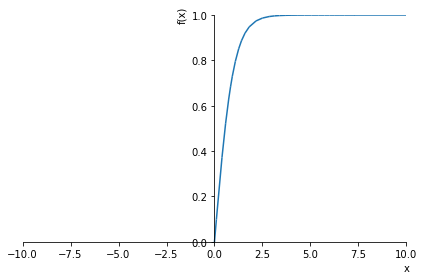

In [148]:
expr = sym.tanh(x)
plot(expr, (x, -10, 10))

/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1065: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1066: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['bottom'].set_smart_bounds(False)


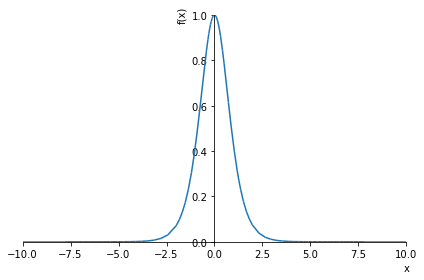

In [139]:
expr = sym.tanh(x)
expr = sym.diff(expr)
plot(expr, (x, -10, 10))

#### Kerasの実装変更

In [151]:
model = Sequential()
model.add(Dense(200, activation='tanh'))
model.add(Dense(200, activation='tanh'))
model.add(Dense(200, activation='tanh'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, t_train,
          epochs=10, batch_size=100,
          verbose=2)

loss, acc = model.evaluate(x_test, t_test, verbose=0)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    loss,
    acc
))

Epoch 1/10
600/600 - 2s - loss: 0.7902 - accuracy: 0.8053
Epoch 2/10
600/600 - 2s - loss: 0.3924 - accuracy: 0.8924
Epoch 3/10
600/600 - 2s - loss: 0.3340 - accuracy: 0.9060
Epoch 4/10
600/600 - 2s - loss: 0.3047 - accuracy: 0.9136
Epoch 5/10
600/600 - 2s - loss: 0.2850 - accuracy: 0.9190
Epoch 6/10
600/600 - 2s - loss: 0.2694 - accuracy: 0.9231
Epoch 7/10
600/600 - 2s - loss: 0.2565 - accuracy: 0.9263
Epoch 8/10
600/600 - 2s - loss: 0.2447 - accuracy: 0.9301
Epoch 9/10
600/600 - 2s - loss: 0.2342 - accuracy: 0.9328
Epoch 10/10
600/600 - 2s - loss: 0.2243 - accuracy: 0.9361
test_loss: 0.219, test_acc: 0.937


### ReLU
- 微分がどこまで行っても１なので、勾配が消失しない

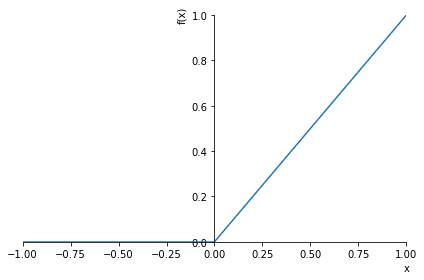

In [154]:
expr = sym.Max(x, 0)
plot(expr, (x, -1, 1))

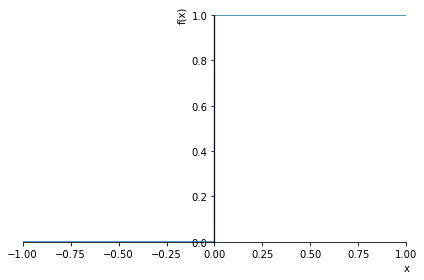

In [155]:
expr = sym.diff(expr)
plot(expr, (x, -1, 1))

### TFによる実装

In [5]:
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

np.random.seed(123)
tf.random.set_seed(123)

In [6]:
mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_test = (x_test.reshape(-1, 784) / 255).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

In [7]:
class DNN(Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = Dense(hidden_dim, activation='relu')
        self.l2 = Dense(hidden_dim, activation='relu')
        self.l3 = Dense(hidden_dim, activation='relu')
        self.l4 = Dense(output_dim, activation='softmax')

        self.ls = [self.l1, self.l2, self.l3, self.l4]

    def call(self, x):
        for layer in self.ls:
            x = layer(x)

        return x

In [8]:
model = DNN(200, 10)

In [9]:
criterion = losses.CategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.01)
train_loss = metrics.Mean()
train_acc = metrics.CategoricalAccuracy()

def compute_loss(t, y):
    return criterion(t, y)

def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = compute_loss(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)

    return loss

In [10]:
epochs = 10
batch_size = 100
n_batches = x_train.shape[0] // batch_size

for epoch in range(epochs):
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(
        epoch+1,
        train_loss.result(),
        train_acc.result()
    ))

epoch: 1, loss: 1.08, acc: 0.735
epoch: 2, loss: 0.737, acc: 0.812
epoch: 3, loss: 0.599, acc: 0.843
epoch: 4, loss: 0.521, acc: 0.862
epoch: 5, loss: 0.469, acc: 0.874
epoch: 6, loss: 0.431, acc: 0.884
epoch: 7, loss: 0.402, acc: 0.891
epoch: 8, loss: 0.377, acc: 0.897
epoch: 9, loss: 0.357, acc: 0.903
epoch: 10, loss: 0.34, acc: 0.907


In [11]:
test_loss = metrics.Mean()
test_acc = metrics.CategoricalAccuracy()

def test_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    test_loss(loss)
    test_acc(t, preds)

    return loss

test_step(x_test, t_test)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss.result(),
    test_acc.result()
))

test_loss: 0.182, test_acc: 0.948


### Leaky ReRU
- x<0でも学習が進むと期待
- 実際は、ケースバイケース。。

/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1065: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1066: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['bottom'].set_smart_bounds(False)


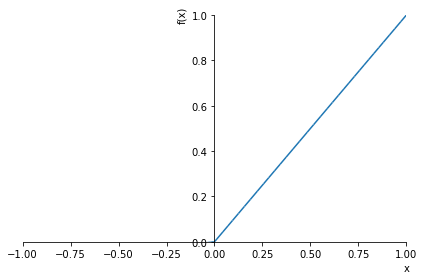

In [14]:
expr = sym.Max(x, 0) + 0.1 * sym.Min(0,x)
plot(expr, (x, -1, 1))

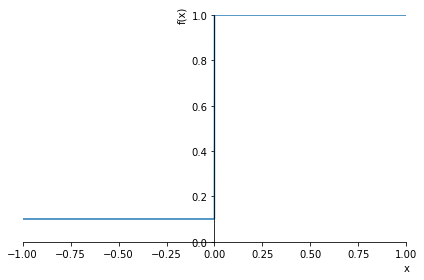

In [15]:
expr = sym.diff(expr)
plot(expr, (x, -1, 1))

### Swish
- ReLUの派生
- いくつかの実験ではReLUよりもいいので、知っておいても損はない（By 著者）

/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1065: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1066: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['bottom'].set_smart_bounds(False)


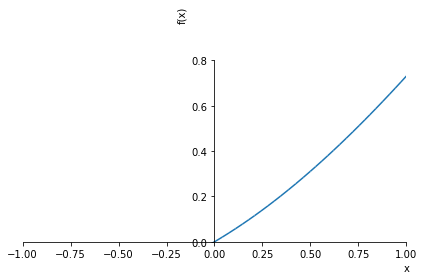

In [16]:
expr = x / (1 + sym.exp(-x))
plot(expr, (x, -1, 1))

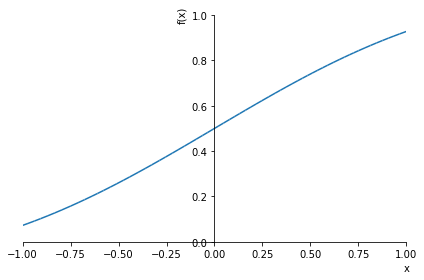

In [17]:
expr = sym.diff(expr)
plot(expr, (x, -1, 1))

#### PyTorchの実装

In [18]:
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

In [19]:
class Swish(nn.Module):
    def __init__(self, beta=1.):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

In [20]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = Swish()
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = Swish()
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = Swish()
        self.l4 = nn.Linear(hidden_dim, output_dim)

        self.layers = [self.l1, self.a1,
                       self.l2, self.a2,
                       self.l3, self.a3,
                       self.l4]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [21]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root=root,
                             download=True,
                             train=True,
                             transform=transform)
mnist_test = datasets.MNIST(root=root,
                            download=True,
                            train=False,
                            transform=transform)

train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                             batch_size=100,
                             shuffle=False)

In [23]:
model = DNN(784, 200, 10).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.SGD(model.parameters(), lr=0.01)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

epochs = 10

for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += \
            accuracy_score(t.tolist(),
                           preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(
        epoch+1,
        train_loss,
        train_acc
    ))

epoch: 1, loss: 2.3, acc: 0.125
epoch: 2, loss: 2.29, acc: 0.174
epoch: 3, loss: 2.27, acc: 0.278
epoch: 4, loss: 2.15, acc: 0.287
epoch: 5, loss: 1.68, acc: 0.519
epoch: 6, loss: 0.817, acc: 0.758
epoch: 7, loss: 0.56, acc: 0.840
epoch: 8, loss: 0.454, acc: 0.872
epoch: 9, loss: 0.405, acc: 0.885
epoch: 10, loss: 0.376, acc: 0.894


In [25]:
def test_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += \
        accuracy_score(t.tolist(),
                       preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss,
    test_acc
))

test_loss: 0.351, test_acc: 0.900


## ドロップアウトの導入

- 一定の確率pでニューロンを除外する
- 擬似的にアンサンブル学習を行っているようなもの
- pは0.3や0.5が一般的
- 計算としては、ニューロンのベクトルを一定確率で0にする（マスクベクトルをかける）

### Keras
- dropout層を加えるだけ

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [29]:
np.random.seed(123)
tf.random.set_seed(123)

mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_test = (x_test.reshape(-1, 784) / 255).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

In [30]:
model = Sequential()
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [32]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, t_train,
          epochs=10, batch_size=100,
          verbose=2)

Epoch 1/10
600/600 - 2s - loss: 1.0833 - accuracy: 0.6340
Epoch 2/10
600/600 - 2s - loss: 0.8235 - accuracy: 0.7307
Epoch 3/10
600/600 - 2s - loss: 0.6868 - accuracy: 0.7824
Epoch 4/10
600/600 - 2s - loss: 0.6025 - accuracy: 0.8138
Epoch 5/10
600/600 - 2s - loss: 0.5452 - accuracy: 0.8345
Epoch 6/10
600/600 - 3s - loss: 0.5019 - accuracy: 0.8497
Epoch 7/10
600/600 - 3s - loss: 0.4680 - accuracy: 0.8610
Epoch 8/10
600/600 - 3s - loss: 0.4399 - accuracy: 0.8721
Epoch 9/10
600/600 - 2s - loss: 0.4181 - accuracy: 0.8793
Epoch 10/10
600/600 - 2s - loss: 0.3953 - accuracy: 0.8862


In [33]:
loss, acc = model.evaluate(x_test, t_test, verbose=0)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    loss,
    acc
))

test_loss: 0.217, test_acc: 0.935


### TF
- Dropout層を追加する

In [34]:
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [35]:
class DNN(Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = Dense(hidden_dim, activation='relu')
        self.d1 = Dropout(0.5)
        self.l2 = Dense(hidden_dim, activation='relu')
        self.d2 = Dropout(0.5)
        self.l3 = Dense(hidden_dim, activation='relu')
        self.d3 = Dropout(0.5)
        self.l4 = Dense(output_dim, activation='softmax')

        self.ls = [self.l1, self.d1,
                   self.l2, self.d2,
                   self.l3, self.d3,
                   self.l4]

    def call(self, x):
        for layer in self.ls:
            x = layer(x)

        return x

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)

'''
1. データの準備
'''
mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_test = (x_test.reshape(-1, 784) / 255).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

'''
2. モデルの構築
'''
model = DNN(200, 10)

'''
3. モデルの学習
'''
criterion = losses.CategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.01)
train_loss = metrics.Mean()
train_acc = metrics.CategoricalAccuracy()

def compute_loss(t, y):
    return criterion(t, y)

def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = compute_loss(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)

    return loss

epochs = 100
batch_size = 100
n_batches = x_train.shape[0] // batch_size

for epoch in range(epochs):
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(
        epoch+1,
        train_loss.result(),
        train_acc.result()
    ))

'''
4. モデルの評価
'''
test_loss = metrics.Mean()
test_acc = metrics.CategoricalAccuracy()

def test_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    test_loss(loss)
    test_acc(t, preds)

    return loss

test_step(x_test, t_test)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss.result(),
    test_acc.result()
))

epoch: 1, loss: 1.08, acc: 0.735
epoch: 2, loss: 0.737, acc: 0.812
epoch: 3, loss: 0.599, acc: 0.843
epoch: 4, loss: 0.521, acc: 0.862
epoch: 5, loss: 0.469, acc: 0.874
epoch: 6, loss: 0.431, acc: 0.884
epoch: 7, loss: 0.402, acc: 0.891
epoch: 8, loss: 0.377, acc: 0.897
epoch: 9, loss: 0.357, acc: 0.903
epoch: 10, loss: 0.34, acc: 0.907
epoch: 11, loss: 0.325, acc: 0.911
epoch: 12, loss: 0.311, acc: 0.915
epoch: 13, loss: 0.299, acc: 0.918
epoch: 14, loss: 0.288, acc: 0.920


### Pytorch

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)

        self.layers = [self.l1, self.a1, self.d1,
                       self.l2, self.a2, self.d2,
                       self.l3, self.a3, self.d3,
                       self.l4]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
1. データの準備
'''
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root=root,
                             download=True,
                             train=True,
                             transform=transform)
mnist_test = datasets.MNIST(root=root,
                            download=True,
                            train=False,
                            transform=transform)

train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                             batch_size=100,
                             shuffle=False)

'''
2. モデルの構築
'''
model = DNN(784, 200, 10).to(device)

'''
3. モデルの学習
'''
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.SGD(model.parameters(), lr=0.01)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

epochs = 100

for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += \
            accuracy_score(t.tolist(),
                           preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(
        epoch+1,
        train_loss,
        train_acc
    ))

'''
4. モデルの評価
'''
def test_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += \
        accuracy_score(t.tolist(),
                       preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss,
    test_acc
))